# Prepare audio data

The data contains a few samples that aren't exactly 1 second long and some samples that are either truncated or don't contain very much of the word.

The code in the notebook attempts to filter out the broken audio so that we are only using good audio.

Then we generate spectrograms of each word. We mix in background noise with the words to make it a more realistic audio sample.

## Download dataset

Download from: https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz - approx 2.3 GB

And then run:
```
tar -xzf data_speech_commands_v0.02.tar.gz -C speech-data
```
to extract data.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
SPEECH_DATA='speech-data'

In [3]:
# The audio is all sampled at 16KHz and should all be 1 second in length - so 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_VOICE_LENGTH=EXPECTED_SAMPLES / 4

In [4]:
# List of folders we want to process in the SPEECH_DATA folder
from tensorflow.python.ops import gen_audio_ops as audio_ops
words = [
    'backward',
    'bed',
    'bird',
    'cat',
    'dog',
    'down',
    'eight',
    'five',
    'follow',
    'forward',
    'four',
    'go',
    'happy',
    'house',
    'learn',
    'left',
    'marvin',
    'nine',
    'no',
    'off',
    'on',
    'one',
    'right',
    'seven',
    'sheila',
    'six',
    'stop',
    'three',
    'tree',
    'two',
    'up',
    'visual',
    'wow',
    'yes',
    'zero',
    '_background',
]

In [5]:
# Get all the files in a directory
def get_files(word):
    return gfile.glob(SPEECH_DATA + '/' + word + '/*.wav')

# Get the location of the voice
def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

# Work out how much of the audio file is actually voice
def get_voice_length(audio, noise_floor):
    position = get_voice_position(audio, noise_floor)
    return (position[1] - position[0]).numpy()

# Is enough voice present?
def is_voice_present(audio, noise_floor, required_length):
    voice_length = get_voice_length(audio, noise_floor)
    return voice_length >= required_length

# Is the audio the correct length?
def is_correct_length(audio, expected_length):
    return (audio.shape[0]==expected_length).numpy()

def is_valid_file(file_name):
    # Load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    # Check the file is long enough
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    # Convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # Is there any voice in the audio?
    if not is_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    return True


In [6]:
# Following function generate a spectrogram from an audio sample.
#
# This function:
#    1) normalise the audio sample to remove any variance in volume
#    2) computes the spectrogram
#    3) reduce data by applying average pooling
#
def get_spectrogram(audio):
    # Normalise the audio
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # Create the spectrogram
    spectrogram = audio_ops.audio_spectrogram(audio,
                                              window_size=320,
                                              stride=160,
                                              magnitude_squared=True).numpy()
    # Reduce the number of frequency bins in our spectrogram to a more sensible level
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    spectrogram = tf.squeeze(spectrogram, axis=0)
    # Take the log of the spectrogram to simplify training
    spectrogram = np.log10(spectrogram + 1e-6)
    return spectrogram

In [7]:
# Process a file into its spectrogram
def process_file(file_path):
    # Load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_path)
    # Convert the audio to an array of floats and scale it to betweem -1 and 1
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    # Randomly reposition the audio in the sample
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    # Add some random background noise
    background_volume = np.random.uniform(0, 0.1)
    # Get the background noise files
    background_files = get_files('_background_noise_')
    background_file = np.random.choice(background_files)
    background_tensor = tfio.audio.AudioIOTensor(background_file)
    background_start = np.random.randint(0, len(background_tensor) - 16000)
    # Normalise the background noise
    background = tf.cast(background_tensor[background_start:background_start + 16000], tf.float32)
    background = background - np.mean(background)
    background = background / np.max(np.abs(background))
    # Mix the audio with the scaled background
    audio = audio + background_volume * background
    # Get the spectrogram
    return get_spectrogram(audio)

In [8]:
train = []
validate = []
test = []

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

In [9]:
def process_files(file_names, label, repeat=1):
    file_names = tf.repeat(file_names, repeat).numpy()
    return [(process_file(file_name), label) for file_name in tqdm(file_names, desc=f"{word} ({label})", leave=False)]

# Process the files for a word into the spectrogram and one hot encoding word value
def process_word(word, repeat=1):
    # The index of the word word we are processing
    label = words.index(word)
    # Get a list of files names for the word
    file_names = [file_name for file_name in tqdm(get_files(word), desc="Checking", leave=False) if is_valid_file(file_name)]
    # Randomly shuffle the filenames
    np.random.shuffle(file_names)
    # Split the files into train, validate and test buckets
    train_size=int(TRAIN_SIZE * len(file_names))
    validation_size=int(VALIDATION_SIZE * len(file_names))
    test_size=int(TEST_SIZE * len(file_names))
    # Get the training samples
    train.extend(
        process_files(
            file_names[:train_size],
            label,
            repeat=repeat
        )
    )
    # Get the validation samples
    validate.extend(
        process_files(
            file_names[train_size:train_size + validation_size],
            label,
            repeat=repeat
        )
    )
    # Get the test samples
    test.extend(
        process_files(
            file_names[train_size + validation_size:],
            label,
            repeat=repeat
        )
    )

# Process all the words and all the files
for word in tqdm(words, desc="Processing words"):
    if '_' not in word:
        # Add more examples of marvin to balance training set
        repeat = 70 if word == 'marvin' else 1
        process_word(word, repeat=repeat)
    
print(len(train), len(test), len(validate))

Processing words:   0%|          | 0/13 [00:00<?, ?it/s]

Checking:   0%|          | 0/1664 [00:00<?, ?it/s]

2022-03-31 16:13:17.472554: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-03-31 16:13:17.939456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 16:13:18.074263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 16:13:18.075099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 16:13:18.080741: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to 

backward (0):   0%|          | 0/1225 [00:00<?, ?it/s]

2022-03-31 16:13:38.629324: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


backward (0):   0%|          | 0/153 [00:00<?, ?it/s]

backward (0):   0%|          | 0/154 [00:00<?, ?it/s]

Checking:   0%|          | 0/3917 [00:00<?, ?it/s]

down (1):   0%|          | 0/2623 [00:00<?, ?it/s]

down (1):   0%|          | 0/327 [00:00<?, ?it/s]

down (1):   0%|          | 0/329 [00:00<?, ?it/s]

Checking:   0%|          | 0/1557 [00:00<?, ?it/s]

forward (2):   0%|          | 0/1113 [00:00<?, ?it/s]

forward (2):   0%|          | 0/139 [00:00<?, ?it/s]

forward (2):   0%|          | 0/140 [00:00<?, ?it/s]

Checking:   0%|          | 0/3801 [00:00<?, ?it/s]

left (3):   0%|          | 0/1876 [00:00<?, ?it/s]

left (3):   0%|          | 0/234 [00:00<?, ?it/s]

left (3):   0%|          | 0/235 [00:00<?, ?it/s]

Checking:   0%|          | 0/2100 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/100660 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/12530 [00:00<?, ?it/s]

marvin (4):   0%|          | 0/12670 [00:00<?, ?it/s]

Checking:   0%|          | 0/3941 [00:00<?, ?it/s]

no (5):   0%|          | 0/2464 [00:00<?, ?it/s]

no (5):   0%|          | 0/308 [00:00<?, ?it/s]

no (5):   0%|          | 0/309 [00:00<?, ?it/s]

Checking:   0%|          | 0/3745 [00:00<?, ?it/s]

off (6):   0%|          | 0/1188 [00:00<?, ?it/s]

off (6):   0%|          | 0/148 [00:00<?, ?it/s]

off (6):   0%|          | 0/150 [00:00<?, ?it/s]

Checking:   0%|          | 0/3845 [00:00<?, ?it/s]

on (7):   0%|          | 0/2390 [00:00<?, ?it/s]

on (7):   0%|          | 0/298 [00:00<?, ?it/s]

on (7):   0%|          | 0/300 [00:00<?, ?it/s]

Checking:   0%|          | 0/3778 [00:00<?, ?it/s]

right (8):   0%|          | 0/2111 [00:00<?, ?it/s]

right (8):   0%|          | 0/263 [00:00<?, ?it/s]

right (8):   0%|          | 0/265 [00:00<?, ?it/s]

Checking:   0%|          | 0/3872 [00:00<?, ?it/s]

stop (9):   0%|          | 0/2001 [00:00<?, ?it/s]

stop (9):   0%|          | 0/250 [00:00<?, ?it/s]

stop (9):   0%|          | 0/251 [00:00<?, ?it/s]

Checking:   0%|          | 0/3723 [00:00<?, ?it/s]

up (10):   0%|          | 0/790 [00:00<?, ?it/s]

up (10):   0%|          | 0/98 [00:00<?, ?it/s]

up (10):   0%|          | 0/100 [00:00<?, ?it/s]

Checking:   0%|          | 0/4044 [00:00<?, ?it/s]

yes (11):   0%|          | 0/2364 [00:00<?, ?it/s]

yes (11):   0%|          | 0/295 [00:00<?, ?it/s]

yes (11):   0%|          | 0/297 [00:00<?, ?it/s]

120805 15200 15043


In [10]:
# Process the background noise files
def process_background(file_name, label):
    # Load the audio file
    audio_tensor = tfio.audio.AudioIOTensor(file_name)
    audio = tf.cast(audio_tensor[:], tf.float32)
    audio_length = len(audio)
    samples = []
    for section_start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 8000), desc=file_name, leave=False):
        section_end = section_start + EXPECTED_SAMPLES
        section = audio[section_start:section_end]
        # Get the spectrogram
        spectrogram = get_spectrogram(section)
        samples.append((spectrogram, label))

    # Simulate random utterances
    for section_index in tqdm(range(1000), desc="Simulated Words", leave=False):
        section_start = np.random.randint(0, audio_length - EXPECTED_SAMPLES)
        section_end = section_start + EXPECTED_SAMPLES
        section = np.reshape(audio[section_start:section_end], (EXPECTED_SAMPLES))

        result = np.zeros((EXPECTED_SAMPLES))
        # Create a pseudo bit of voice
        voice_length = np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start = np.random.randint(0, EXPECTED_SAMPLES - voice_length)
        hamming = np.hamming(voice_length)
        # Amplify the voice section
        result[voice_start:voice_start+voice_length] = hamming * section[voice_start:voice_start+voice_length]
        # Get the spectrogram
        spectrogram = get_spectrogram(np.reshape(section, (16000, 1)))
        samples.append((spectrogram, label))
        
    
    np.random.shuffle(samples)
    
    train_size=int(TRAIN_SIZE * len(samples))
    validation_size=int(VALIDATION_SIZE * len(samples))
    test_size=int(TEST_SIZE * len(samples))
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size +validation_size])
    test.extend(samples[train_size + validation_size:])

        
for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    process_background(file_name, words.index("_background"))
    
print(len(train), len(test), len(validate))

Processing Background Noise:   0%|          | 0/6 [00:00<?, ?it/s]

speech-data/_background_noise_/white_noise.wav:   0%|          | 0/118 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech-data/_background_noise_/pink_noise.wav:   0%|          | 0/118 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech-data/_background_noise_/exercise_bike.wav:   0%|          | 0/121 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech-data/_background_noise_/doing_the_dishes.wav:   0%|          | 0/189 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech-data/_background_noise_/dude_miaowing.wav:   0%|          | 0/122 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech-data/_background_noise_/running_tap.wav:   0%|          | 0/121 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

126233 15885 15719


In [11]:
print(len(train), len(test), len(validate))

126233 15885 15719


In [12]:
# Randomise the training samples
np.random.shuffle(train)

In [13]:
X_train, Y_train = zip(*train)
X_validate, Y_validate = zip(*validate)
X_test, Y_test = zip(*test)

In [14]:
# Save the computed data
np.savez_compressed(
    "training-spectrogram.npz",
    X=X_train, Y=Y_train)
print("Saved training data")
np.savez_compressed(
    "validation-spectrogram.npz",
    X=X_validate, Y=Y_validate)
print("Saved validation data")
np.savez_compressed(
    "test-spectrogram.npz",
    X=X_test, Y=Y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [15]:
# Get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

In [16]:
def plot_images2(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(5, 5, figsize=(10, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    

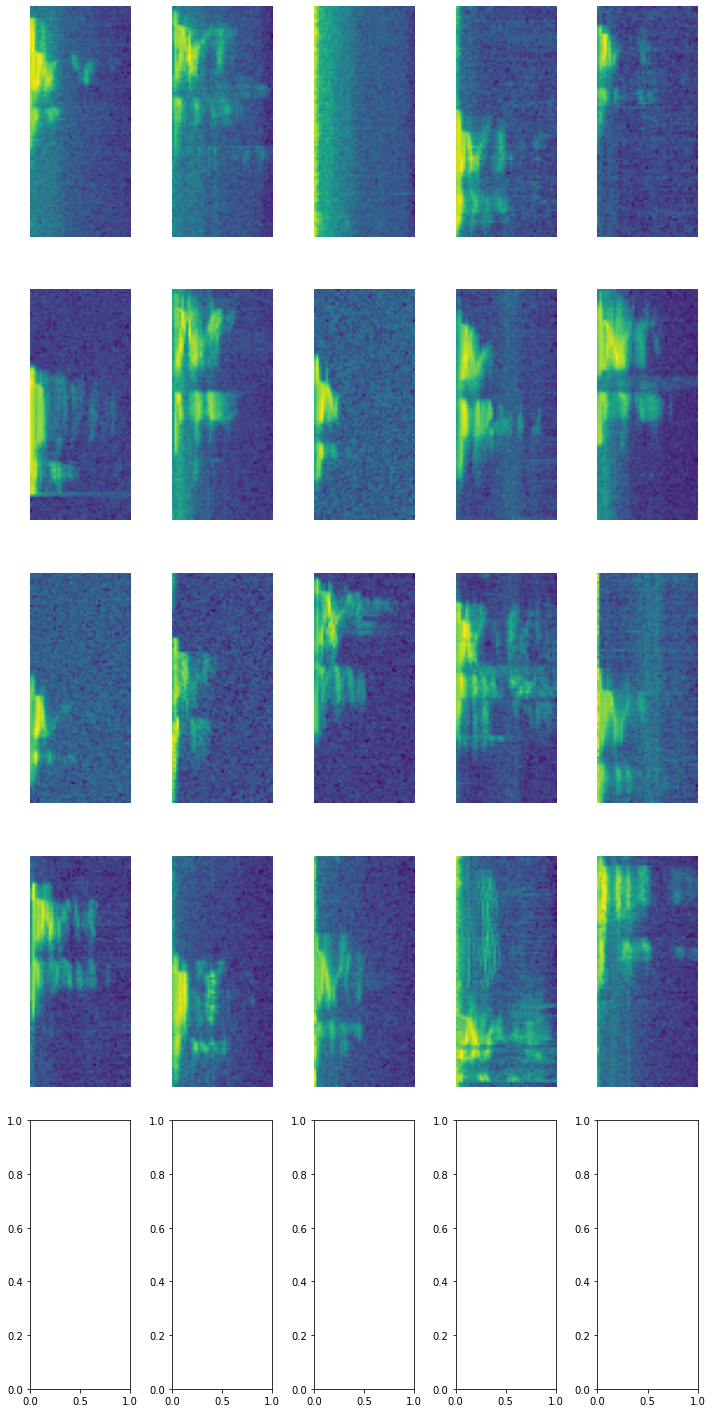

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [17]:
word_index = words.index("marvin")

X_marvins = np.array(X_train)[np.array(Y_train) == word_index]
Y_marvins = np.array(Y_train)[np.array(Y_train) == word_index]
plot_images2(X_marvins[:20], IMG_WIDTH, IMG_HEIGHT)
print(Y_marvins[:20])

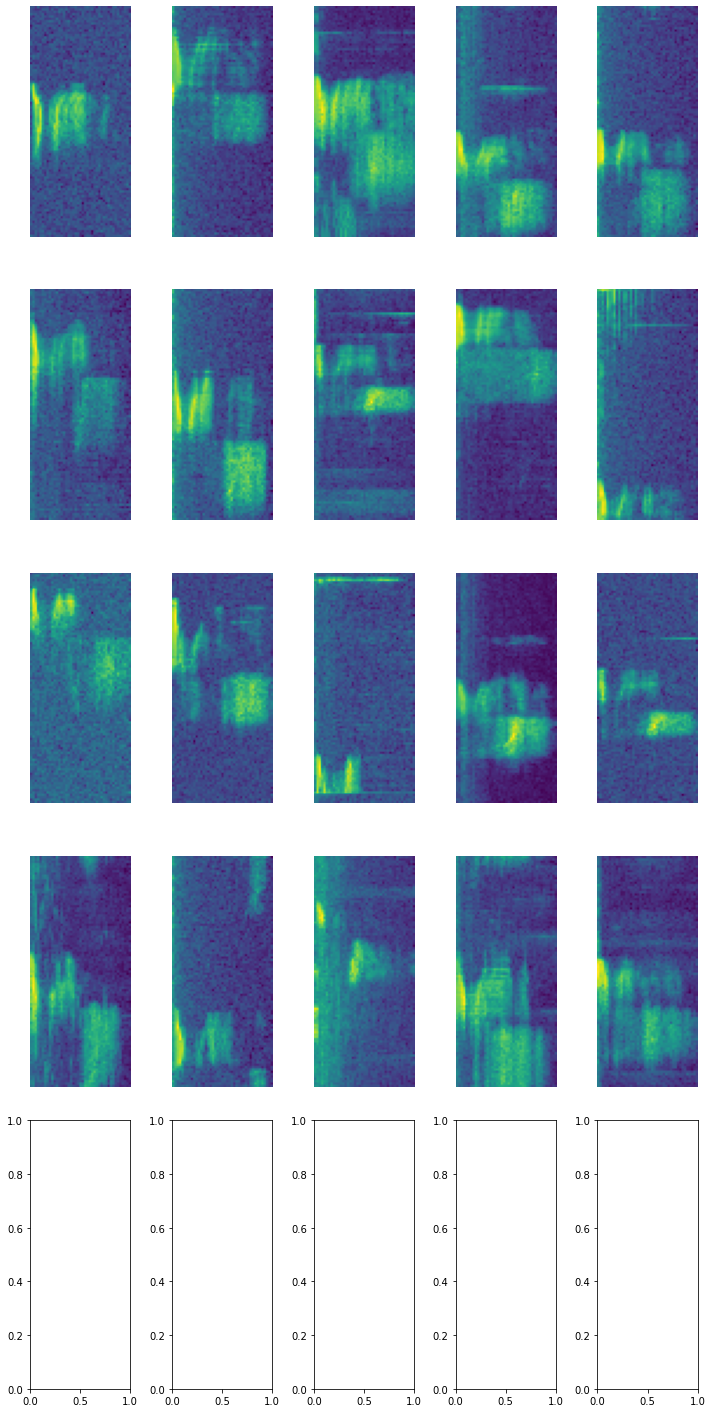

[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11]


In [18]:
word_index = words.index("yes")

X_yes = np.array(X_train)[np.array(Y_train) == word_index]
Y_yes = np.array(Y_train)[np.array(Y_train) == word_index]
plot_images2(X_yes[:20], IMG_WIDTH, IMG_HEIGHT)
print(Y_yes[:20])